<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Authors: [Vitaliy Radchenko](https://www.linkedin.com/in/vitaliyradchenk0/), Data Scientist at YouScan, and [Yury Kashnitskiy](https://www.linkedin.com/in/festline/), Data Scientist at Mail.ru Group <br>
Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Anna Shirshova](http://linkedin.com/in/anna-shirshova-b908458b), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/).

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center> Topic 5. Composition of algorithms, random forest</center>
## <center> Part 3. Feature importance</center>

Pretty often, you would like to make out the exact reasons why the algorithm outputted a particular answer. Or, not being able to understand the algorithm completely, then st lest we’d like to find out which input features contributed the most to the result. With Random Forest, you can obtain such information quite easily.

### Outline

1. Essence of the method
2. Practical example

### 1. Essence of the method 

From the picture below, it is intuitively clear that, in our credit scoring problem, *Age* is much more important than *Income*. This can be formally explained using the concept of *information gain*.

<img src="../../img/credit_scoring_toy_tree_english.png" align='center'>

In the case of many decision trees or a random forest, the closer the mean position of a feature over all the trees to the root, the more significant it is for a given classification or regression problem. Gains in the splitting criterion, such as the *Gini impurity*, obtained at each optimal split in every tree is a measure of importance that is directly associated with the splitting feature. The value of this score is distinct for each feature and accumulates over all the trees.

Let's go a little deeper into the details. 

The average reduction in accuracy caused by a variable is determined during the calculation of the out-of-bag error. The greater the reduction in accuracy due to an exclusion or permutation of the variable, the higher its *importance score*. For this reason, variables with a greater average reduction in accuracy are generally more significant for classification.

The average reduction in the Gini impurity – or *MSE* for regression – represents the contribution of each variable to the homogeneity of nodes and leaves in the resulting Random Forest model. Every time a selected variable is used for splitting, the Gini impurity of the child nodes is calculated and compared with that of the original node.

The Gini impurity is a score of homogenity with the range from $0$ (homogeneous) to $1$ (heterogeneous). The changes in the value of the splitting criterion are accumulated for each variable and normalized at the end of the calculation. A higher reduction in the Gini impurity signals that splitting results by this variable results in nodes with higher purity.

Now, let's represent this method in analytic form:

$$\large VI^{T} = \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_i^{T}\Big)}{\Big |\mathfrak{B}^T\Big |} - \frac{\sum_{i \in \mathfrak{B}^T}I \Big(y_i=\hat{y}_{i,\pi_j}^{T}\Big)}{\Big |\mathfrak{B}^T\Big |}$$

where

* $\large \hat{y}_i^{(T)} = f^{T}(x_i)$ is a class prediction before the feature permutation or exclusion;
* $\large \hat{y}_{i,\pi_j}^{(T)} = f^{T}(x_{i,\pi_j})$ is a class prediction after the feature permutation or exclusion;
* and $\large x_{i,\pi_j} = (x_{i,1}, \dots , x_{i,j-1}, \quad x_{\pi_j(i),j}, \quad x_{i,j+1}, \dots , x_{i,p})$.
 
Note that $\large VI^{T}(x_j) = 0$ if $\large x_j$ is not in the tree $\large T$.

Now, we can give the feature importance calculation for ensembles

* not normalized:

$$ \large VI(x_j) = \frac{\sum_{T=1}^{N}VI^{T}(x_j)}{N} $$

* normalized by the standard deviation of the differences:

$$ \large z_j = \frac{VI(x_j)}{\frac{\hat{\sigma}}{\sqrt{N}}} $$

### 2. Practical example

Let's consider the results of a survey given to visitors of hostels listed on Booking.com and TripAdvisor.com. Our features here are the average ratings for different categories include service quality, room condition, value for money, etc. Our target variable is the hostel's overall rating on the website.

In [1]:
from __future__ import division, print_function

# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Set the font for titles in Russian
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

Feature ranking:
1. Staff 0.182757 
2. Value for money 0.148373 
3. Shared space condition 0.128296 
4. Extra services 0.116604 
5. Customer Co-creation 0.106668 
6. General conditions & conveniences 0.088589 
7. Shared kitchen condition 0.074273 
8. Check-in and check-out 0.061521 
9. Hostel booking 0.053615 
10. Room condition 0.039305 


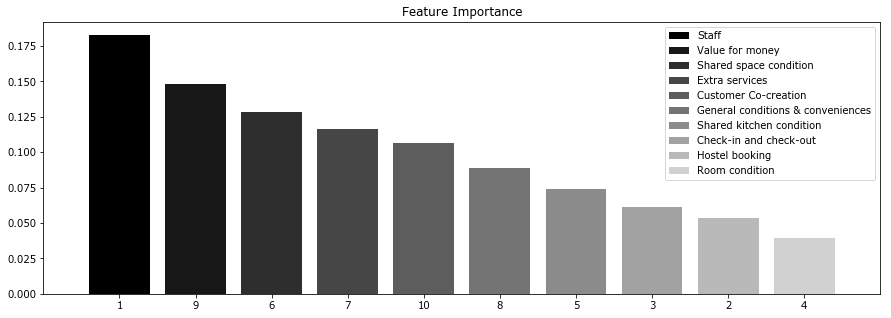

In [2]:
hostel_data = pd.read_csv("../../data/hostel_factors.csv")
features = {"f1":u"Staff",
"f2":u"Hostel booking",
"f3":u"Check-in and check-out",
"f4":u"Room condition",
"f5":u"Shared kitchen condition",
"f6":u"Shared space condition",
"f7":u"Extra services",
"f8":u"General conditions & conveniences",
"f9":u"Value for money",
"f10":u"Customer Co-creation"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

The picture above shows that, more often than not, customers pay great attention to staff and the price-quality ratio. This couple of factors affects the resulting overall rating the most. But, the difference between these two features and other festures is not very large. We can therefore conclude that exclusion of any of these features will lead to a reduction in model accuracy. Based on our analysis, we csn recommend hostel owners to focus primarily on staff training and price-to-quality ratio.

### Useful resources
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) based on this notebook
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/324402/) on Habrahabr with ~ the same material. And a [lecture](https://youtu.be/G0DmuuFeC30) on YouTube
- Chapter 15 of the book “[Elements of Statistical Learning](https://statweb.stanford.edu/~tibs/ElemStatLearn/)” by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie.
- More about practical applications of random forests and other algorithms can be found in the [official documentation](http://scikit-learn.org/stable/modules/ensemble.html) of `scikit-learn`.
- For more in-depth discussion of variance and decorrelation of random forests, see the [original paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf).